In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from py2neo import Graph, Node, Relationship

In [ ]:
g = Graph(password="admin")

tx = g.begin()
john = Node("User", name="John", gender="M", age="28")
tx.create(john)

mary = Node("User", name="Mary", gender="F", age="26")
tx.create(mary)

jm = Relationship(john, "FRIENDS_WITH", mary)
tx.create(jm)

tx.commit()

In [3]:
# Load data, define hover text and bubble size
data = px.data.gapminder()
df_2007 = data[data['year']==2007]
df_2007 = df_2007.sort_values(['continent', 'country'])

hover_text = []
bubble_size = []

for index, row in df_2007.iterrows():
    hover_text.append(('Country: {country}<br>'+
                      'Life Expectancy: {lifeExp}<br>'+
                      'GDP per capita: {gdp}<br>'+
                      'Population: {pop}<br>'+
                      'Year: {year}').format(country=row['country'],
                                            lifeExp=row['lifeExp'],
                                            gdp=row['gdpPercap'],
                                            pop=row['pop'],
                                            year=row['year']))
    bubble_size.append(math.sqrt(row['pop']))

df_2007['text'] = hover_text
df_2007['size'] = bubble_size
sizeref = 2.*max(df_2007['size'])/(100**2)

# Dictionary with dataframes for each continent
continent_names = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
continent_data = {continent:df_2007.query("continent == '%s'" %continent)
                              for continent in continent_names}

# Create figure
fig = go.Figure()

for continent_name, continent in continent_data.items():
    fig.add_trace(go.Scatter(
        x=continent['gdpPercap'], y=continent['lifeExp'],
        name=continent_name, text=continent['text'],
        marker_size=continent['size'],
        ))

# Tune marker appearance and layout
fig.update_traces(mode='markers', marker=dict(sizemode='area',
                                              sizeref=sizeref, line_width=2))

fig.update_layout(
    title='Life Expectancy v. Per Capita GDP, 2007',
    xaxis=dict(
        title='GDP per capita (2000 dollars)',
        gridcolor='white',
        type='log',
        gridwidth=2,
    ),
    yaxis=dict(
        title='Life Expectancy (years)',
        gridcolor='white',
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)
fig.show()

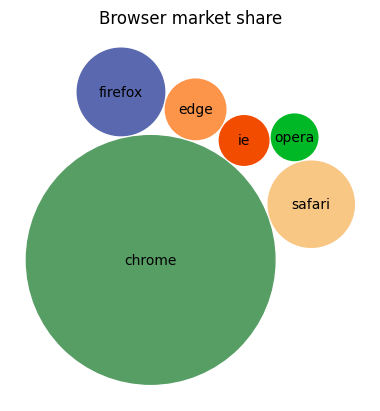

In [4]:


browser_market_share = {
    'browsers': ['firefox', 'chrome', 'safari', 'edge', 'ie', 'opera'],
    'market_share': [8.61, 69.55, 8.36, 4.12, 2.76, 2.43],
    'color': ['#5A69AF', '#579E65', '#F9C784', '#FC944A', '#F24C00', '#00B825']
}


class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


bubble_chart = BubbleChart(area=browser_market_share['market_share'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, browser_market_share['browsers'], browser_market_share['color'])
ax.set_axis_off()
ax.relim()
ax.autoscale_view()
ax.set_title('Browser market share')

plt.show()

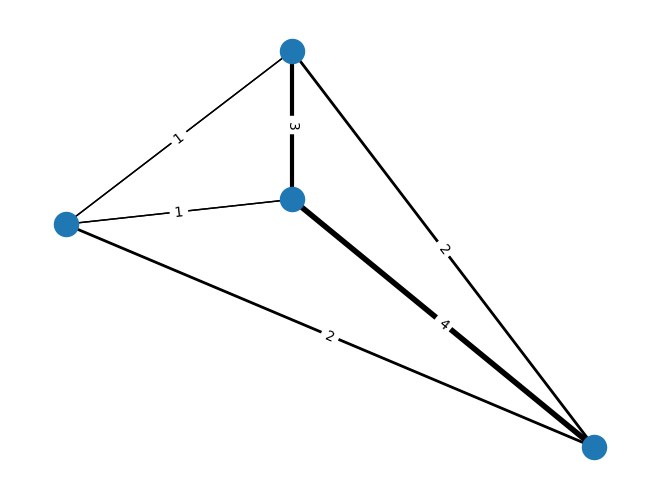

In [5]:
G = nx.Graph()
G.add_node('A', pos=(0,5),text="test")
G.add_node('B', pos=(3,12))
G.add_node('C', pos=(3,6))
G.add_node('D', pos=(7,-4))
weights = [1, 1, 2, 3, 2, 4]
G.add_edge('A', 'B', weight=weights[0])
G.add_edge('A', 'C', weight=weights[1])
G.add_edge('A', 'D', weight=weights[2])
G.add_edge('B', 'C', weight=weights[3])
G.add_edge('B', 'D', weight=weights[4])
G.add_edge('C', 'D', weight=weights[5])
pos=nx.get_node_attributes(G,'pos')
 
labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos)
nx.draw_networkx_edges(G, pos, width=weights)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
 
plt.show()